In [44]:
#this is the block of code that generates unrealized profits for companies for which portfolia holder has only bought stocks as
#well as bought and sold the stocks both.

import pandas as pd
from fpdf import FPDF
import yfinance as yf

# Load the Excel file
df_xlsx = pd.read_excel("Core_Portfolio.xlsx", sheet_name = "TRANSACTIONS" , skiprows=2)
# Filter buy and sell data
data_for_buy = df_xlsx[df_xlsx['TYPE'] == 'Buy']
data_for_sell = df_xlsx[df_xlsx['TYPE'] == 'Sell']

# Summarize the quantities by ticker
buy_summary = data_for_buy.groupby('EXCHANGE CODE: TICKER')['UNITS'].sum().to_dict()
sell_summary = data_for_sell.groupby('EXCHANGE CODE: TICKER')['UNITS'].sum().to_dict()
buy_price_dict = data_for_buy.groupby('EXCHANGE CODE: TICKER')['AMOUNT'].sum().to_dict()
sell_price_dict = data_for_sell.groupby('EXCHANGE CODE: TICKER')['AMOUNT'].sum().to_dict()


'''generates a table of all the stock holdings'''
# Function to fetch the current stock price using yfinance for Indian stocks
def get_stock_price(ticker):
    try:
        # Assuming NSE symbols, append '.NS' to the ticker. Adjust if using BSE.
        stock = yf.Ticker(f"{ticker[4:]}.NS") if ticker[0:3] == 'NSE' else yf.Ticker(f"{ticker[4:]}.BO") 
        price = stock.history(period="1d")['Close'].iloc[-1]  # Get the latest closing price
        return round(float(price), 2)
    except Exception as e:
        print(f"Error fetching price for {ticker[4:]}: {e}")
        return None

net_quant = {key: round((buy_summary[key] - sell_summary.get(key, 0)), 5) for key in buy_summary if round((buy_summary[key] - sell_summary.get(key, 0)), 5) != 0}
average_buy_price_dict = {key: ((buy_price_dict[key]-sell_price_dict.get(key, 0))/net_quant[key]) for key in net_quant }
total_unrealized_profit = 0
# Calculate the remaining stock and get the current price
result = {}
for key in average_buy_price_dict:
    buy_quantity = buy_summary.get(key, 0)
    sell_quantity = sell_summary.get(key, 0)
    remaining_quantity = buy_quantity - sell_quantity
    
    # Only process if remaining quantity is greater than zero
    if remaining_quantity != 0:
        buy_price = average_buy_price_dict.get(key, 0)
        current_price = get_stock_price(key)
        
        if current_price is not None:
            current_value = round(remaining_quantity * current_price, 2)
            unrealized_profit = current_value - (buy_price * remaining_quantity)
            total_cost_of_remaining_shares = buy_price * remaining_quantity
            profit_percentage = (unrealized_profit / total_cost_of_remaining_shares) * 100 
            total_unrealized_profit += unrealized_profit
            result[key] = [
                round(remaining_quantity, 10),  # Remaining quantity
                current_price,  # Current price of the stock
                round(buy_price,5),  # Price at which the stock was bought
                round(unrealized_profit, 2),  # Unrealized profit
                current_value,  # Current value of the portfolio/investment
                round(profit_percentage, 2)  # Profit percentage
            ]

# Print the result
print(result)

{'NSE:ABBOTINDIA': [0.68, 30195.85, 19403.41176, 7338.86, 20533.18, 55.62], 'NSE:APOLLOHOSP': [3.6, 6927.5, 5972.0, 3439.8, 24939.0, 16.0], 'NSE:ASHOKLEY': [66.85, 256.45, 224.23897, 2153.31, 17143.68, 14.36], 'NSE:BAJEL': [46.35, 268.85, 206.11823, 2907.62, 12461.2, 30.43], 'NSE:BIKAJI': [27.46, 825.1, 369.95235, 12498.36, 22657.25, 123.03], 'NSE:CENTURYPLY': [21.42, 786.75, 691.9, 2031.69, 16852.19, 13.71], 'NSE:HAVELLS': [14.28, 1899.35, 1599.2437, 4285.52, 27122.72, 18.77], 'NSE:HCLTECH': [14.04, 1753.25, 1520.05698, 3274.03, 24615.63, 15.34], 'NSE:IEX': [92.52, 203.63, 148.0, 5146.89, 18839.85, 37.59], 'NSE:INDUSTOWER': [40.85, 458.5, 446.0, 510.63, 18729.73, 2.8], 'NSE:KSCL': [13.8, 1050.6, 794.74493, 3530.8, 14498.28, 32.19], 'NSE:MARUTI': [1.78, 12403.0, 12793.14607, -694.46, 22077.34, -3.05], 'NSE:METROPOLIS': [7.13, 2139.8, 988.71304, 8207.25, 15256.77, 116.42], 'NSE:MSUMI': [257.97, 70.43, 55.73838, 3790.0, 18168.83, 26.36], 'NSE:PRAJIND': [20.76, 766.9, 357.31792, 8502.92, 

#### '''generating the introductory data for the client ie the current market value and the total investment value and other things'''
total_investment_value_data = (df_xlsx[df_xlsx['TYPE']=='Cash Deposit'])
val = list((total_investment_value_data.groupby('EXCHANGE CODE: TICKER')['PRICE'].sum().to_dict()).values())
total_investment_value = val[0] #gets the total amount of money that is invested by the portfolio holder
print(total_investment_value)
print(total_cash_balance)
value_buy_sum = data_for_buy['Value'].sum()
value_sell_sum = data_for_sell['Value'].sum()
total_val_list = [(result[i])[4] for i in result]
total_value = sum(total_val_list)
print(total_value)
total_cash_balance =  df_xlsx['Cash Balance'].iloc[-1]
market_value = round(total_cash_balance + total_value,2) # gets the total market value
print(market_value)

In [15]:
'''generating the booked and total profit/loss'''
net_quant_is_zero_dict = {key: round((buy_summary[key] - sell_summary.get(key, 0)), 5) for key in buy_summary if round((buy_summary[key] - sell_summary.get(key, 0)), 5) == 0}
# Calculate the remaining stock and get the current price
result_with_remaining_zero = {}
for key in net_quant_is_zero_dict:
    buy_quantity = buy_summary.get(key, 0)
    sell_quantity = sell_summary.get(key, 0)
    remaining_quantity = buy_quantity - sell_quantity
    buy_price = buy_price_dict.get(key, 0)
    current_price = get_stock_price(key)
    sell_price = sell_price_dict.get(key, 0)
    if current_price is not None:
        current_value = round(remaining_quantity * current_price, 2)
        booked_profit = (sell_price - buy_price) 
        result_with_remaining_zero[key] = round(booked_profit, 2)  # booked profit

# calculating the total booked profit 
total_booked_profit = sum(list(result_with_remaining_zero.values()))
# Print the result with remaining quantity zero
print(total_booked_profit)
print(total_unrealized_profit)
total_profit_or_loss = round(total_booked_profit  + total_unrealized_profit,2)
print(total_profit_or_loss)

225786.28
82230.10290000001
308016.38


In [29]:
ticker_list = list(result.keys())
df_mcap = pd.read_excel("Mcap_stock_codes.xlsx")

# Filter tickers
filtered_ticker_list = [ticker[4:] for ticker in ticker_list]
filtered_df_mcap = df_mcap[df_mcap['NSE Symbol'].isin(filtered_ticker_list)]

# Initialize the final dictionary to store all values
cap_values = {}

# Calculate Large Cap values
large_cap = filtered_df_mcap[filtered_df_mcap['Categorization as per SEBI Circular dated Oct 6, 2017'] == 'Large Cap']
total_large_cap_value = 0
for ticker in large_cap['NSE Symbol']:
    nse_ticker = f"NSE:{ticker}"
    if nse_ticker in list(result.keys()):
        total_large_cap_value += result[nse_ticker][4]  # Adding the 'current_value'

cap_values['Large Cap'] = round(total_large_cap_value,2)

# Calculate Mid Cap values
mid_cap = filtered_df_mcap[filtered_df_mcap['Categorization as per SEBI Circular dated Oct 6, 2017'] == 'Mid Cap']
total_mid_cap_value = 0
for ticker in mid_cap['NSE Symbol']:
    nse_ticker = f"NSE:{ticker}"
    if nse_ticker in list(result.keys()):
        total_mid_cap_value += result[nse_ticker][4]  # Adding the 'current_value'

cap_values['Mid Cap'] = round(total_mid_cap_value,2)

# Calculate Small Cap values
small_cap = filtered_df_mcap[filtered_df_mcap['Categorization as per SEBI Circular dated Oct 6, 2017'] == 'Small Cap']
total_small_cap_value = 0
for ticker in small_cap['NSE Symbol']:
    nse_ticker = f"NSE:{ticker}"
    if nse_ticker in list(result.keys()):
        total_small_cap_value += result[nse_ticker][4]  # Adding the 'current_value'

cap_values['Small Cap'] = round(total_small_cap_value,2)

# Print the final dictionary with all cap values
cap_values['Cash'] = float(total_cash_balance)
print(cap_values)

{'Large Cap': 136573.45, 'Mid Cap': 84135.32, 'Small Cap': 161241.73, 'Cash': 5384.0}


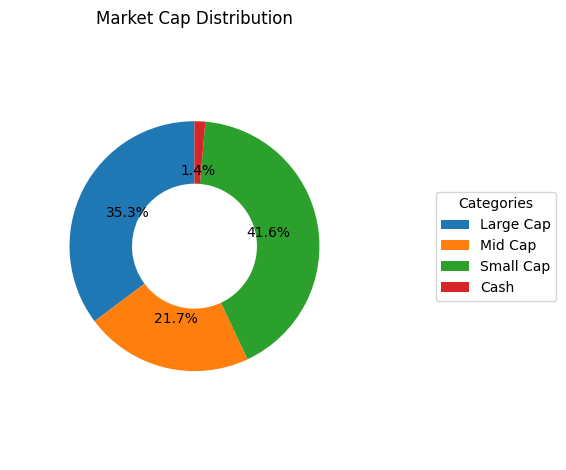

In [30]:
import matplotlib.pyplot as plt

# Calculate the total value
total_value = sum(cap_values.values())

# Calculate percentages for each category
percentages = {key: (value / total_value) * 100 for key, value in cap_values.items()}

# Create a list of labels and sizes
labels = list(percentages.keys())
sizes = list(percentages.values())

# Plotting the donut chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5)
)

# Add a legend with labels
ax.legend(wedges, labels, title="Categories", loc="center right", bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Title
plt.title("Market Cap Distribution")
plt.tight_layout()
plt.savefig('mcap_donut_chart.png')
# Display the chart
plt.show()


In [31]:
import pandas as pd

# Read the market cap and sector allocation files
df_mcap = pd.read_excel("Mcap_stock_codes.xlsx")
df_sector_allocation = pd.read_excel("sector_allocation.xlsx")

# Filter tickers for both market cap and sector allocation
filtered_ticker_list = [ticker[4:] for ticker in ticker_list]
filtered_df_mcap = df_mcap[df_mcap['NSE Symbol'].isin(filtered_ticker_list)]
filtered_df_sector_allocation = df_sector_allocation[df_sector_allocation['NSE Symbol'].isin(filtered_ticker_list)]

# Initialize the final dictionaries to store all cap and sector values
sector_values = {}
# Group the sector allocation data by sector and calculate the total current value for each sector
sectors = filtered_df_sector_allocation.groupby('Sector')

for sector, group in sectors:
    total_sector_value = 0
    for ticker in group['NSE Symbol']:
        nse_ticker = f"NSE:{ticker}"
        if nse_ticker in list(result.keys()):
            total_sector_value += result[nse_ticker][4]  # Adding the 'current_value'
    
    sector_values[sector] = round(total_sector_value, 2)

# Add the cash balance to both dictionaries if needed

print(sector_values)


{'Commodities': 37640.76, 'Consumer Discretionary': 102251.76, 'Fast Moving Consumer Goods': 22698.44, 'Financial Services': 33475.35, 'Healthcare': 60812.62, 'Industrials': 33138.99, 'Information Technology': 40450.7, 'Telecommunication': 18570.41, 'Utilities': 10655.5}


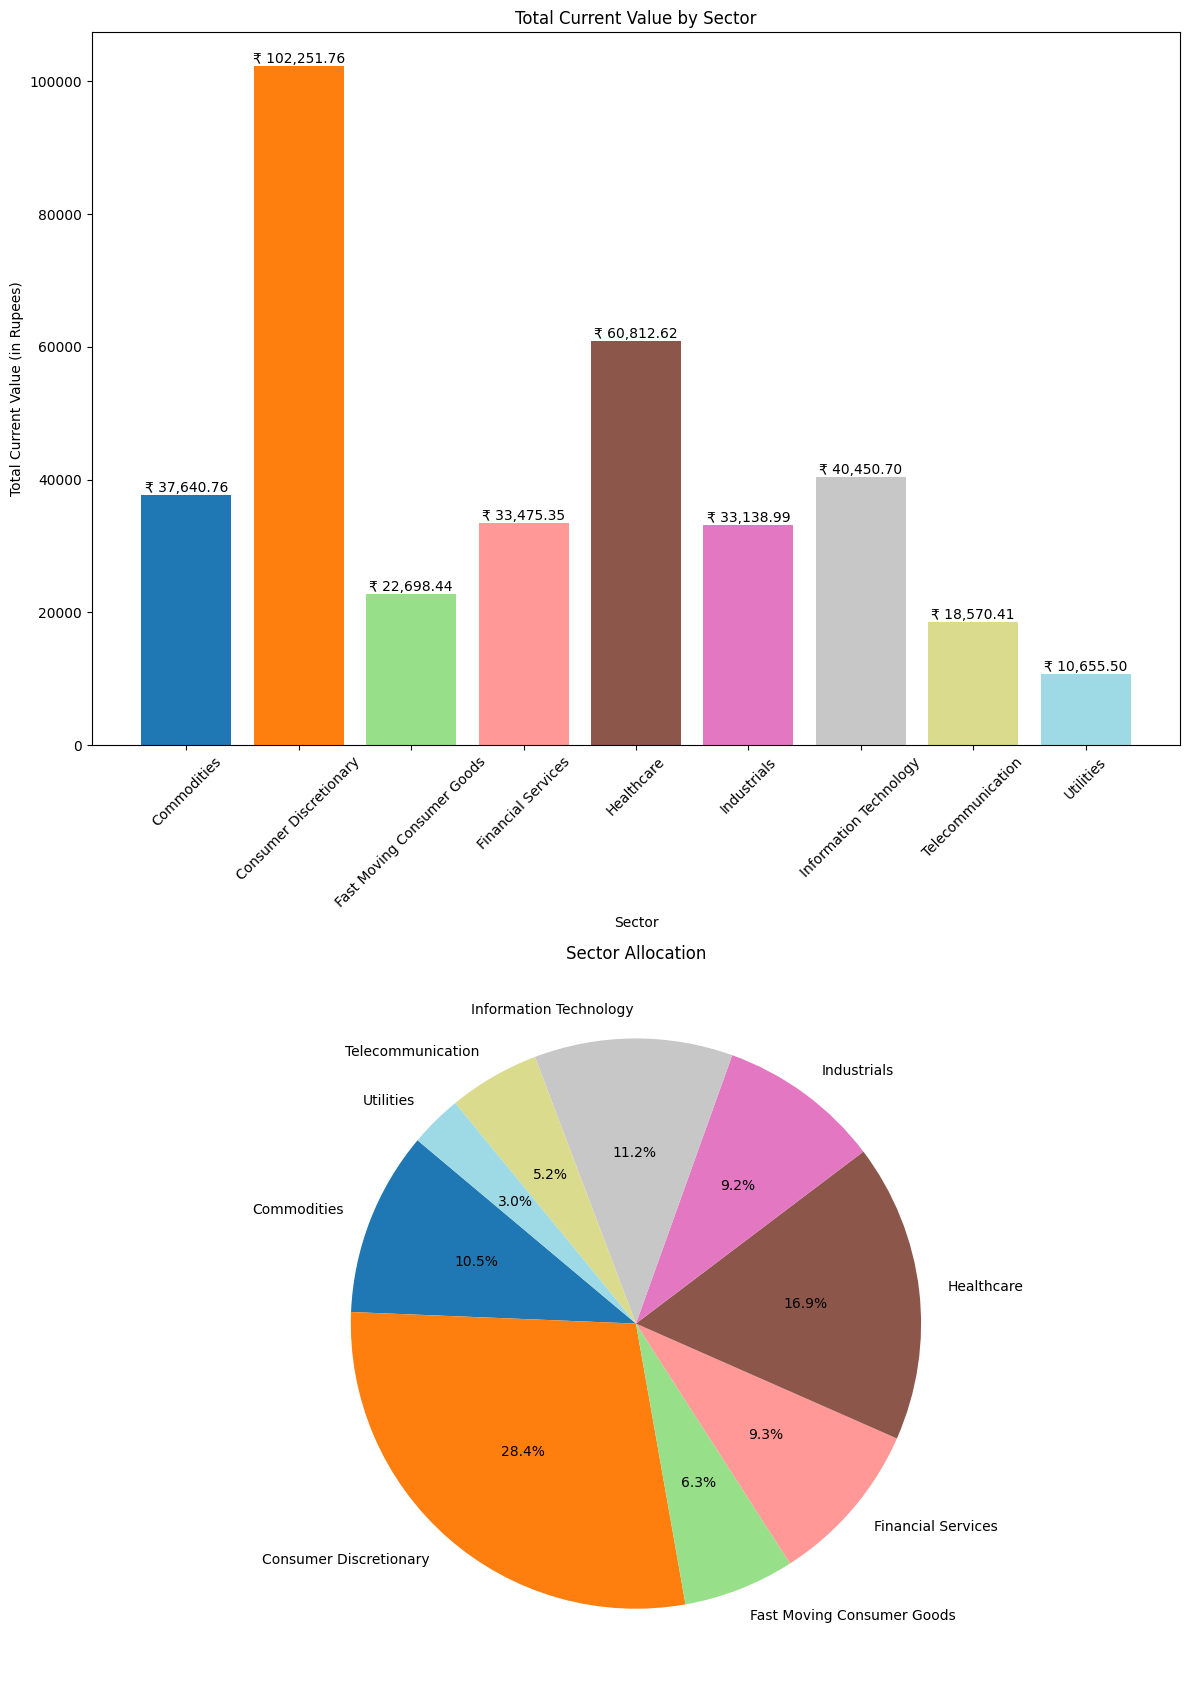

In [32]:
import matplotlib.pyplot as plt
import numpy as np

rupee_sign = "\u20B9"
# Extracting the sector names and their corresponding values
sectors = list(sector_values.keys())
values = list(sector_values.values())

# Define a list of colors, one for each sector
colors = plt.cm.tab20(np.linspace(0, 1, len(sectors)))  # Using a colormap with distinct colors

# Create a single figure for both plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 17))

# Bar chart
bars = ax1.bar(sectors, values, color=colors)
ax1.set_xlabel('Sector')
ax1.set_ylabel('Total Current Value (in Rupees)')
ax1.set_title('Total Current Value by Sector')
ax1.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{rupee_sign} {height:,.2f}', 
             ha='center', va='bottom')

# Pie chart
ax2.pie(values, labels=sectors, colors=colors, autopct='%1.1f%%', startangle=140)
ax2.set_title('Sector Allocation')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('combined_charts.png')
plt.show()
plt.close()


In [20]:
from fpdf import FPDF
from babel.numbers import format_decimal

# Initialize the PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=10)
pdf.add_page()

# Add a background color for the title
pdf.set_fill_color(200, 220, 255)
pdf.set_font("Arial", "B", 12)  # Bold font for the title
pdf.cell(0, 12, txt="Stock Portfolio Summary", ln=True, align="C", fill=True)
pdf.ln(10)
pdf.set_right_margin(10)

# Add introductory data with bold labels
pdf.set_font("Arial", "B", 10)
pdf.set_text_color(0, 0, 0)

# Format the numbers with Indian commas
formatted_investment_value =  format_decimal(total_investment_value, locale='en_IN')
formatted_market_value     =  format_decimal(market_value, locale='en_IN')
formatted_booked_profit    =  format_decimal(total_booked_profit, locale='en_IN')
formatted_total_profit     =  format_decimal(total_profit_or_loss, locale='en_IN')

# Total Investment Value and Market Value
pdf.cell(50, 10, txt="Total Investment Value:", border=0, align="L")
pdf.set_font("Arial", "", 10)
pdf.cell(50, 10, txt=formatted_investment_value, border=0, align="L")
pdf.set_font("Arial", "B", 10)
pdf.cell(50, 10, txt="Market Value:", border=0, align="L")
pdf.set_font("Arial", "", 10)
pdf.cell(50, 10, txt=formatted_market_value, border=0, align="L")
pdf.ln(10)

# Booked Profit/Loss and Total Profit/Loss
pdf.set_font("Arial", "B", 10)
pdf.cell(50, 10, txt="Booked Profit/Loss:", border=0, align="L")
pdf.set_font("Arial", "", 10)
pdf.cell(50, 10, txt=formatted_booked_profit, border=0, align="L")
pdf.set_font("Arial", "B", 10)
pdf.cell(50, 10, txt="Total Profit/Loss:", border=0, align="L")
pdf.set_font("Arial", "", 10)
pdf.cell(50, 10, txt=formatted_total_profit, border=0, align="L")
pdf.ln(20)

# Set column headers with a background color and border, bold text
pdf.set_fill_color(105, 105, 105)  # Dark gray
pdf.set_text_color(255, 255, 255)  # White text for headers
pdf.set_font("Arial", "B", 10)  # Bold font for headers

# Adjust the width of each column so that it fits within the page
pdf.cell(25, 10, txt="Stock", border=1, align="C", fill=True)
pdf.cell(30, 10, txt="Net Quantity", border=1, align="C", fill=True)
pdf.cell(25, 10, txt="Buy Price", border=1, align="C", fill=True)
pdf.cell(25, 10, txt="Current Price", border=1, align="C", fill=True)
pdf.cell(25, 10, txt="Profit/Loss", border=1, align="C", fill=True)
pdf.cell(30, 10, txt="Profit/Loss%", border=1, align="C", fill=True)
pdf.cell(35, 10, txt="Current Value", border=1, align="C", fill=True)
pdf.ln()

# Add data rows
pdf.set_font("Arial", "", 10)  # Standard font size for data rows
pdf.set_text_color(0, 0, 0)  # Black text for data

for idx, (key, value) in enumerate(result.items()):
    # Alternate row background color for better readability
    if idx % 2 == 0:
        pdf.set_fill_color(245, 245, 245)  # Light gray
        fill = True
    else:
        fill = False

    # Add stock name and quantities
    pdf.cell(25, 10, txt=key[4:], border=1, align="C", fill=fill)  # Stock name without the exchange prefix
    pdf.cell(30, 10, txt=format_decimal(value[0], locale='en_IN'), border=1, align="C", fill=fill)  # Total quantities
    
    # Add buy price
    pdf.cell(25, 10, txt=format_decimal(value[2], locale='en_IN'), border=1, align="C", fill=fill)  # Buy price
    
    # Add current price
    pdf.cell(25, 10, txt=format_decimal(value[1], locale='en_IN'), border=1, align="C", fill=fill)  # Current price

    # Add profit with color coding
    if value[3] >= 0:
        pdf.set_text_color(0, 128, 0)  # Green for profit
    else:
        pdf.set_text_color(255, 0, 0)  # Red for loss
    pdf.cell(25, 10, txt=format_decimal(value[3], locale='en_IN'), border=1, align="C", fill=fill)  # Profit/Loss
    pdf.set_text_color(0, 0, 0)  # Reset text color to black
    
    # Add profit percentage with color coding
    if value[5] >= 0:
        pdf.set_text_color(0, 128, 0)  # Green for positive percentage
    else:
        pdf.set_text_color(255, 0, 0)  # Red for negative percentage
    pdf.cell(30, 10, txt=f"{value[5]:,.2f}%", border=1, align="C", fill=fill)  # Profit percentage
    
    # Reset text color to black and add current value
    pdf.set_text_color(0, 0, 0)
    pdf.cell(35, 10, txt=format_decimal(value[4], locale='en_IN'), border=1, align="C", fill=fill)  # Current value
    pdf.ln()

# Add a footer
pdf.set_y(-15)
pdf.set_font("Arial", "I", 8)  # Footer font size
pdf.set_text_color(128, 128, 128)
pdf.cell(0, 10, txt="End of Report", align="C")

# Save the PDF to a file
pdf.output("stock_portfolio2.pdf")

print("PDF created successfully.")


PDF created successfully.


In [33]:
'''this block of code generates the pdf of the portfolio holdings along with the booked profit/loss, total profit/loss, 
   makrket value, etc. '''

from fpdf import FPDF
from babel.numbers import format_decimal

# Initialize the PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=10)
pdf.add_page()

# Add a background color for the title
pdf.set_fill_color(200, 220, 255)
pdf.set_font("Arial", "B", 12)  # Bold font for the title
pdf.cell(0, 12, txt="Stock Portfolio Summary", ln=True, align="C", fill=True)
pdf.ln(5)
pdf.set_right_margin(10)

# Add introductory data with bold labels
pdf.set_font("Arial", "B", 10)
pdf.set_text_color(0, 0, 0)

# Format the numbers with Indian commas
formatted_investment_value =  format_decimal(total_investment_value, locale='en_IN')
formatted_market_value     =  format_decimal(market_value, locale='en_IN')
formatted_booked_profit    =  format_decimal(total_booked_profit, locale='en_IN')
formatted_total_profit     =  format_decimal(total_profit_or_loss, locale='en_IN')

# Total Investment Value and Market Value
pdf.cell(50, 10, txt="Total Investment Value:", border=0, align="L")
pdf.set_font("Arial", "", 10)
pdf.cell(50, 10, txt=formatted_investment_value, border=0, align="L")
pdf.set_font("Arial", "B", 10)
pdf.cell(50, 10, txt="Market Value:", border=0, align="L")
pdf.set_font("Arial", "", 10)
pdf.cell(50, 10, txt=formatted_market_value, border=0, align="L")
pdf.ln(7)

# Booked Profit/Loss and Total Profit/Loss
pdf.set_font("Arial", "B", 10)
pdf.cell(50, 10, txt="Booked Profit/Loss:", border=0, align="L")
pdf.set_font("Arial", "", 10)
pdf.cell(50, 10, txt=formatted_booked_profit, border=0, align="L")
pdf.set_font("Arial", "B", 10)
pdf.cell(50, 10, txt="Total Profit/Loss:", border=0, align="L")
pdf.set_font("Arial", "", 10)
pdf.cell(50, 10, txt=formatted_total_profit, border=0, align="L")
pdf.ln(10)

# Set column headers with a background color and border, bold text
pdf.set_fill_color(105, 105, 105)  # Dark gray
pdf.set_text_color(255, 255, 255)  # White text for headers
pdf.set_font("Arial", "B", 10)  # Bold font for headers

# Adjust the width of each column so that it fits within the page
pdf.cell(30, 10, txt="Stock",        border=1, align="C", fill=True)
pdf.cell(30, 10, txt="Net Quantity", border=1, align="C", fill=True)
pdf.cell(25, 10, txt="Buy Price",    border=1, align="C", fill=True)
pdf.cell(25, 10, txt="Current Price",border=1, align="C", fill=True)
pdf.cell(25, 10, txt="Profit/Loss",  border=1, align="C", fill=True)
pdf.cell(30, 10, txt="Profit/Loss%", border=1, align="C", fill=True)
pdf.cell(30, 10, txt="Current Value",border=1, align="C", fill=True)
pdf.ln()

# Add data rows
pdf.set_font("Arial", "", 10)  # Standard font size for data rows
pdf.set_text_color(0, 0, 0)  # Black text for data

for idx, (key, value) in enumerate(result.items()):
    # Alternate row background color for better readability
    if idx % 2 == 0:
        pdf.set_fill_color(245, 245, 245)  # Light gray
        fill = True
    else:
        fill = False

    # Add stock name and quantities
    pdf.cell(30, 10, txt=key[4:], border=1, align="C", fill=fill)  # Stock name without the exchange prefix
    pdf.cell(30, 10, txt=format_decimal(value[0], locale='en_IN'), border=1, align="C", fill=fill)  # Total quantities
    
    # Add buy price
    pdf.cell(25, 10, txt=format_decimal(value[2], locale='en_IN'), border=1, align="C", fill=fill)  # Buy price
    
    # Add current price
    pdf.cell(25, 10, txt=format_decimal(value[1], locale='en_IN'), border=1, align="C", fill=fill)

    # Add profit with color coding
    if value[3] >= 0:
        pdf.set_text_color(0, 128, 0)  # Green for profit
    else:
        pdf.set_text_color(255, 0, 0)  # Red for loss
    pdf.cell(25, 10, txt=format_decimal(value[3], locale='en_IN'), border=1, align="C", fill=fill)  # Profit/Loss
    pdf.set_text_color(0, 0, 0)  # Reset text color to black
    
    # Add profit percentage with color coding
    if value[5] >= 0:
        pdf.set_text_color(0, 128, 0)  # Green for positive percentage
    else:
        pdf.set_text_color(255, 0, 0)  # Red for negative percentage
    pdf.cell(30, 10, txt=f"{value[5]:,.2f}%", border=1, align="C", fill=fill)  # Profit percentage
    
    # Reset text color to black and add current value
    pdf.set_text_color(0, 0, 0)
    pdf.cell(30, 10, txt=format_decimal(value[4], locale='en_IN'), border=1, align="C", fill=fill)  # Current value
    pdf.ln()

# Add the charts in the same section
pdf.add_page()                 

# Insert the bar chart image
pdf.image("combined_charts.png", x=10, y=10, w=190)  # Adjust x, y, w as needed

# Move down to add the pie chart
pdf.add_page()

# Insert the pie chart image
pdf.image("mcap_donut_chart.png", x=50, y=10, w=150)  # Adjust x, y, w as needed

# Add a footer
pdf.set_y(-15)
pdf.set_font("Arial", "I", 8)  # Footer font size
pdf.set_text_color(128, 128, 128)
pdf.cell(0, 10, txt="End of Report", align="C")

# Save the PDF to a file
pdf.output("stock_portfolio_with_charts.pdf")

print("PDF with charts created successfully.")


PDF with charts created successfully.


In [55]:
import pandas as pd

# Load the Excel file (replace 'file_path.xlsx' with the actual file path)
df = pd.read_excel("Core_Portfolio.xlsx", sheet_name = "TRANSACTIONS" , skiprows=2)

# Convert the 'TXN DATE' column to datetime format for sorting and manipulation
df['TXN DATE'] = pd.to_datetime(df['TXN DATE'], format='%d-%b-%y')

# Sort the DataFrame by 'TXN DATE' to ensure chronological order
df = df.sort_values(by='TXN DATE')

# Initialize a dictionary to store transactions for each ticker
transactions_dict = {}

# Group by the 'EXCHANGE CODE: TICKER' column
for ticker, group in df.groupby('EXCHANGE CODE: TICKER'):
    # Initialize lists to store buy and sell dates for the current ticker
    ticker_transactions = []
    buy_dates = []

    # Iterate over the rows of the grouped DataFrame
    for index, row in group.iterrows():
        if row['TYPE'] == 'Buy':
            # Append the buy date in desired format
            buy_dates.append(row['TXN DATE'].strftime('%d/%m/%y'))
        elif row['TYPE'] == 'Sell' and buy_dates:
            # Pair the oldest unpaired buy date with the current sell date
            buy_date = buy_dates.pop(0)  # Get the oldest unpaired buy date
            sell_date = row['TXN DATE'].strftime('%d/%m/%y')  # Convert to desired format
            ticker_transactions.append([buy_date, sell_date])
    
    # Add the transactions to the dictionary
    transactions_dict[ticker.upper()] = ticker_transactions
    
print(transactions_dict)

df_corporate_action = pd.read_excel("Corporate_Action.xlsx", sheet_name = "SPLIT", )

{'NSE:AARTIIND': [['20/11/19', '15/02/22']], 'NSE:ABBOTINDIA': [['28/05/19', '23/09/19'], ['10/08/20', '29/10/21']], 'NSE:AETHER': [['19/07/23', '12/04/24']], 'NSE:AKZOINDIA': [['31/10/19', '21/12/21']], 'NSE:ALKEM': [['05/06/20', '15/09/21']], 'NSE:ALKYLAMINE': [['07/02/20', '08/06/20']], 'NSE:APOLLOHOSP': [], 'NSE:ASHOKLEY': [], 'NSE:ATUL': [['28/06/19', '22/12/20']], 'NSE:BAJEL': [['27/02/24', '24/05/24']], 'NSE:BANKBARODA': [['19/07/23', '12/04/24']], 'NSE:BBTC': [['23/12/22', '21/11/23']], 'NSE:BIKAJI': [['19/07/23', '24/05/24'], ['24/07/23', '15/07/24'], ['26/07/23', '28/08/24']], 'NSE:BSOFT': [['29/07/21', '23/05/22']], 'NSE:CCL': [['28/01/22', '19/07/23']], 'NSE:CENTURYPLY': [], 'NSE:CYIENT': [['18/08/23', '05/12/23']], 'NSE:CASH': [], 'NSE:DCMSHRIRAM': [['03/05/19', '20/05/19']], 'NSE:DIXON': [['18/08/23', '12/04/24']], 'NSE:DLF': [['19/07/23', '28/12/23'], ['24/07/23', '12/04/24']], 'NSE:ELGIEQUIP': [['26/05/23', '19/07/23']], 'NSE:FEDERALBNK': [['22/08/23', '20/11/23']], 'NS

{'nse:aartiind': [['20/11/19', '15/02/22']], 'nse:abbotindia': [['28/05/19', '23/09/19'], ['10/08/20', '29/10/21']], 'nse:aether': [['19/07/23', '12/04/24']], 'nse:akzoindia': [['31/10/19', '21/12/21']], 'nse:alkem': [['05/06/20', '15/09/21']], 'nse:alkylamine': [['07/02/20', '08/06/20']], 'nse:apollohosp': [], 'nse:ashokley': [], 'nse:atul': [['28/06/19', '22/12/20']], 'nse:bajel': [['27/02/24', '24/05/24']], 'nse:bankbaroda': [['19/07/23', '12/04/24']], 'nse:bbtc': [['23/12/22', '21/11/23']], 'nse:bikaji': [['19/07/23', '24/05/24'], ['24/07/23', '15/07/24'], ['26/07/23', '28/08/24']], 'nse:bsoft': [['29/07/21', '23/05/22']], 'nse:ccl': [['28/01/22', '19/07/23']], 'nse:centuryply': [], 'nse:cyient': [['18/08/23', '05/12/23']], 'nse:cash': [], 'nse:dcmshriram': [['03/05/19', '20/05/19']], 'nse:dixon': [['18/08/23', '12/04/24']], 'nse:dlf': [['19/07/23', '28/12/23'], ['24/07/23', '12/04/24']], 'nse:elgiequip': [['26/05/23', '19/07/23']], 'nse:federalbnk': [['22/08/23', '20/11/23']], 'ns